In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# plt.style.use('dark_background')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.miscmodels.ordinal_model import OrderedModel

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [2]:
NORMALIZE_TARGET = True
TARGET_VARIABLE = 'cyc_collisions'

# Data

In [3]:
features_df = pd.read_csv('data/processed/image_features.csv')
intersections_df = pd.read_csv('data/processed/intersection_collision_frequency.csv')
df = pd.merge(intersections_df, features_df, how='left', left_on='dupe_key', right_on='image_name')
display(df.head(3).T)
print(f'Shape: {df.shape}')

,0,1,2
lat,40.744167,40.681686,40.811651
lng,-73.91248,-73.87157,-73.914474
intersection,True,True,True
lat_int,40.744167,40.681686,40.811651
lng_int,-73.91248,-73.87157,-73.914474
...,...,...,...
cw_side3_length,NaN,159.380049,NaN
cw_side3_width,NaN,56.067243,NaN
cw_side4_length,NaN,493.82183,NaN
cw_side4_width,NaN,45.38479,NaN


Shape: (39162, 66)


In [4]:
df[df.total_collisions_sum > 0].shape

(33525, 66)

### Remove Low Quality Observations

In [5]:
df = df[df.placename == 'New York']
df = df[df.total_collisions_sum > 0]
df = df[df.intersection_total_count > 0]
df = df[df.overpass_center != 1]
df = df[df.overpass_area <= 0.5]
df = df.set_index('dupe_key', drop=True)
df = df.fillna(0)
df.shape

(27121, 65)

### Generate Features

In [7]:
# Aggregations
df['bike_lane_signage_index'] = (0.7 * df['bikeLane_total_count'] + 0.3 * df['bikeLaneInt_total_count'])
# df['bike_lane_signage_index'] = df.apply(categorize_bike_infrastructure, axis=1)
df['max_int_length'] = df[['int_side1_length', 'int_side2_length', 'int_side3_length', 'int_side4_length']].max(axis=1)
df['int_perimeter'] = df['int_side1_length'] + df['int_side2_length'] + df['int_side3_length'] + df['int_side4_length']
df['total_crosswalk_length'] = df['cw_side1_length'] + df['cw_side2_length'] + df['cw_side3_length'] + df['cw_side4_length']
df['crosswalk_gap'] = df['int_perimeter'] - df['total_crosswalk_length']
df['avg_crosswalk_width'] = df[['cw_side1_width', 'cw_side2_width', 'cw_side3_width', 'cw_side4_width']].mean(axis=1)
df['complexity_index'] = (
    df['intersection_total_count'] + df['crosswalk_total_count'] + df['median_total_count'] + 
    df['doubleYellow_total_count'] # + df['busLane_total_count']
) # * df['intersection_main_area']

# Interactions
df['complexity_x_signage'] = df['complexity_index'] * df['bike_lane_signage_index']
df['complexity_x_width'] = df['complexity_index'] * df['avg_crosswalk_width']
df['buslane_x_bikelane'] = df['busLane_total_count'] * df['bike_lane_signage_index']
df['area_x_complexity'] = df['intersection_main_area'] * df['complexity_index']

# Polynomials
# TBD

df.shape

(27121, 76)

### Drop Irrelevant Features

In [8]:
df = df.drop([
    # Used for bike_lane_signage_index
    'bikeLane_total_count', 'bikeLaneInt_total_count', 'bikeLane_main_count', 'bikeLaneInt_main_count',
    # Used for int_perimeter
    'int_side1_length', 'int_side2_length', 'int_side3_length', 'int_side4_length',
    # Used for total_crosswalk_length and crosswalk_gap
    'cw_side1_length', 'cw_side2_length', 'cw_side3_length', 'cw_side4_length',
    # Used for avg_crosswalk_width
    'cw_side1_width', 'cw_side2_width', 'cw_side3_width', 'cw_side4_width',
    # Used for complexity_index
    'intersection_total_count', 'crosswalk_total_count', 'median_total_count', 'doubleYellow_total_count',
    # Not used
    'crosswalk_main_count', 'median_main_count', 'doubleYellow_main_count', 'busLane_main_count',
    'overpass_main_count', 'overpass_total_count', 
    # Found to be near-constant
    'overhead_area', 'overpass_center',
    # Multicolinearity
    'int_perimeter', 'total_crosswalk_length', # 'boro_name',
    # Leftover features from initial queries
    'image_name', 'lat', 'lng', 'intersection', 'lat_int', 'lng_int', 'mtfcc1', 'mtfcc2',
    'adminCode1', 'adminName1', 'distance_site_int', 'distance', 'bearing', 'placename', 
    'street1Bearing', 'street2Bearing', 'postalcode', 'countryCode', 'street1', 'street2',
    'adminName2'
], axis=1)

df.shape

(27121, 25)

### Normalize Features

In [9]:
scaler = MinMaxScaler()
numerical_predictors = [x for x in df.columns if '_sum' not in x and x != 'boro_name']
df[numerical_predictors] = scaler.fit_transform(df[numerical_predictors])

numerical_predictors

['busLane_total_count',
 'overpass_area',
 'intersection_main_area',
 'bike_lane_signage_index',
 'max_int_length',
 'crosswalk_gap',
 'avg_crosswalk_width',
 'complexity_index',
 'complexity_x_signage',
 'complexity_x_width',
 'buslane_x_bikelane',
 'area_x_complexity']

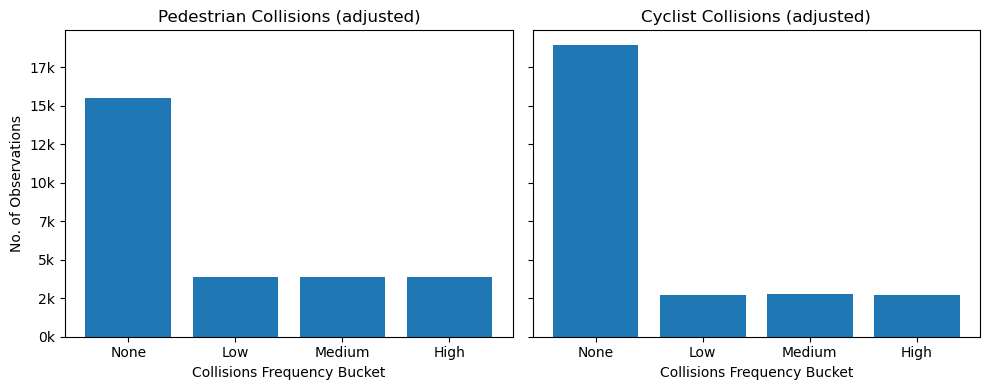

In [10]:
manual_cutoffs = {
    'ped': np.array([-1.,  0.0012987,  0.09302326,  0.19444444,  1.]),
    'cyc': np.array([-1.,  0.0012987,  0.07407407,  0.15873016,  1.]),
}
categories = ['None', 'Low', 'Medium', 'High']

df['ped_collisions'] = df['ped_collisions_sum'] / df['total_collisions_sum']
df['cyc_collisions'] = df['cyc_collisions_sum'] / df['total_collisions_sum']

df['ped_collisions_buckets'] = pd.cut(df['ped_collisions'], bins=manual_cutoffs['ped'], labels=categories)
df['cyc_collisions_buckets'] = pd.cut(df['cyc_collisions'], bins=manual_cutoffs['cyc'], labels=categories)

cat_type = pd.api.types.CategoricalDtype(categories=categories, ordered=True)
df['ped_collisions_buckets'] = df['ped_collisions_buckets'].astype(cat_type)
df['cyc_collisions_buckets'] = df['cyc_collisions_buckets'].astype(cat_type)

# Create value counts with consistent ordering
ped_counts = df['ped_collisions_buckets'].value_counts().reindex(categories)
cyc_counts = df['cyc_collisions_buckets'].value_counts().reindex(categories)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].bar(ped_counts.index, ped_counts.values)
axes[1].bar(cyc_counts.index, cyc_counts.values)

axes[0].set_title('Pedestrian Collisions (adjusted)')
axes[0].set_xlabel('Collisions Frequency Bucket')
axes[0].set_ylabel('No. of Observations')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

axes[1].set_title('Cyclist Collisions (adjusted)')
axes[1].set_xlabel('Collisions Frequency Bucket')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}k'))

plt.tight_layout()
plt.show()

### Normalize Target and Define Buckets

In [11]:
def optimize_buckets(df, collision_col, max_buckets=6):
   from sklearn.metrics import silhouette_score
   from sklearn.preprocessing import KBinsDiscretizer
   
   # Separate zero and non-zero collisions
   non_zero_mask = df[collision_col] > 0
   X = df.loc[non_zero_mask, collision_col].values.reshape(-1, 1)
   
   scores = {}
   cutoffs = {}
   
   for n_bins in range(2, max_buckets):  # -1 to account for zero bin
       for strategy in ['uniform', 'quantile']:
           discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
           labels = discretizer.fit_transform(X).ravel()
           
           if len(np.unique(labels)) > 1:
               score = silhouette_score(X, labels)
               scores[f'{n_bins+1}_{strategy}'] = score  # +1 to account for zero bin
               edges = np.insert(discretizer.bin_edges_[0], 0, -1)  # Add zero boundary
               cutoffs[f'{n_bins+1}_{strategy}'] = edges
   
   return scores, cutoffs

In [12]:
if NORMALIZE_TARGET:
    df[f'{TARGET_VARIABLE}'] = (df[f'{TARGET_VARIABLE}_sum'] / df['total_collisions_sum']).fillna(0)
else:
    df[f'{TARGET_VARIABLE}'] = df[f'{TARGET_VARIABLE}_sum']

scores, cutoffs = optimize_buckets(df, f'{TARGET_VARIABLE}')

display(pd.DataFrame(scores, index=['Silhouette Score']))
display(cutoffs)

,3_uniform,3_quantile,4_uniform,4_quantile,5_uniform,5_quantile,6_uniform,6_quantile
Silhouette Score,0.807786,0.427413,0.697422,0.391156,0.646603,0.405361,0.625048,0.417153


{'3_uniform': array([-1.        ,  0.0012987 ,  0.50064935,  1.        ]),
 '3_quantile': array([-1.        ,  0.0012987 ,  0.10958904,  1.        ]),
 '4_uniform': array([-1.        ,  0.0012987 ,  0.33419913,  0.66709957,  1.        ]),
 '4_quantile': array([-1.        ,  0.0012987 ,  0.07407407,  0.15873016,  1.        ]),
 '5_uniform': array([-1.        ,  0.0012987 ,  0.25097403,  0.50064935,  0.75032468,
         1.        ]),
 '5_quantile': array([-1.        ,  0.0012987 ,  0.05882353,  0.10958904,  0.2       ,
         1.        ]),
 '6_uniform': array([-1.        ,  0.0012987 ,  0.20103896,  0.40077922,  0.60051948,
         0.80025974,  1.        ]),
 '6_quantile': array([-1.        ,  0.0012987 ,  0.05      ,  0.08695652,  0.13636364,
         0.22916667,  1.        ])}

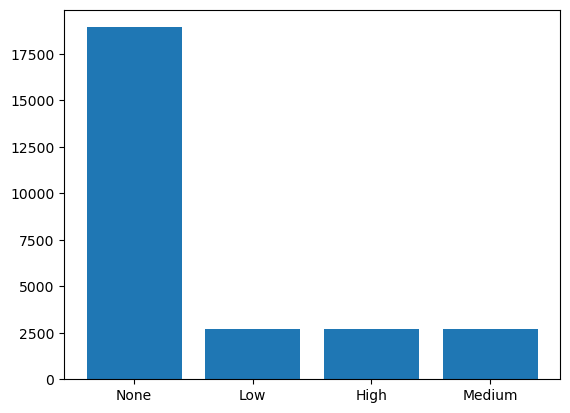

cyc_collisions_buckets
None      18934
Low        2731
High       2729
Medium     2727
Name: count, dtype: int64

In [13]:
cutoffs = cutoffs['4_quantile']
categories = ['None', 'Low', 'Medium', 'High']

df[f'{TARGET_VARIABLE}_buckets'] = pd.cut(df[f'{TARGET_VARIABLE}'], bins=cutoffs, labels=categories)
cat_type = pd.api.types.CategoricalDtype(categories=categories, ordered=True)
df[f'{TARGET_VARIABLE}_buckets'] = df[f'{TARGET_VARIABLE}_buckets'].astype(cat_type)

plt.figure()
plt.bar(df[f'{TARGET_VARIABLE}_buckets'].value_counts().index, df[f'{TARGET_VARIABLE}_buckets'].value_counts().values)
plt.show()

display(df[f'{TARGET_VARIABLE}_buckets'].value_counts())

# Fit Model

In [14]:
# Prepare data for ordinal regression
X = df[[
    x for x in df.columns 
    if '_collision' not in x
    and '_sum' not in x
    and x != 'boro_name'
]]
y = df[f'{TARGET_VARIABLE}_buckets']

# Fit an ordinal regression model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# Summarize the results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.867563
         Iterations: 136
         Function evaluations: 138
         Gradient evaluations: 138
                               OrderedModel Results                               
Dep. Variable:     cyc_collisions_buckets   Log-Likelihood:                -23529.
Model:                       OrderedModel   AIC:                         4.709e+04
Method:                Maximum Likelihood   BIC:                         4.721e+04
Date:                    Sun, 15 Dec 2024                                         
Time:                            15:12:24                                         
No. Observations:                   27121                                         
Df Residuals:                       27106                                         
Df Model:                              12                                         
                              coef    std err          z      P>|z|      [0.02

### Diagnostics

In [15]:
def test_proportional_odds(features_df, target_series):
    """
    Test proportional odds assumption using likelihood ratio test.
    Compare constrained (proportional odds) vs unconstrained models.
    
    Parameters:
    features_df (pd.DataFrame): DataFrame containing feature columns
    target_series (pd.Series): Series containing ordinal outcome variable
    """
    from scipy import stats

    # Fit original model (constrained)
    constrained_model = OrderedModel(
        target_series, features_df, distr='logit'
    ).fit(maxiter=5000)
    ll_constrained = constrained_model.llf

    # Fit separate binary models for each threshold
    ll_unconstrained = 0
    categories = target_series.cat.categories  # Get ordered categories
    
    for i in range(len(categories) - 1):
        # Create binary outcome for this threshold
        binary_outcome = (target_series > categories[i]).astype(int)
        
        # Fit binary logistic regression
        binary_model = sm.Logit(binary_outcome, features_df).fit(disp=0)
        ll_unconstrained += binary_model.llf
    
    # Calculate likelihood ratio test statistic
    lr_stat = -2 * (ll_constrained - ll_unconstrained)
    df_diff = len(features_df.columns) * (len(categories) - 2)  # degrees of freedom
    p_value = stats.chi2.sf(lr_stat, df_diff)
    
    results = {
        'test_statistic': lr_stat,
        'degrees_of_freedom': df_diff,
        'p_value': p_value,
        'proportional_odds_assumed': p_value > 0.05
    }
    
    # Print results in a readable format
    print("\nProportional Odds Assumption Test Results:")
    print(f"Test Statistic: {lr_stat:.2f}")
    print(f"Degrees of Freedom: {df_diff}")
    print(f"P-value: {p_value:.4f}")
    print(f"Assumption holds: {p_value > 0.05}")
    
    return results

def calculate_pseudo_r2_metrics(model_results):
    """
    Calculate multiple pseudo R-squared measures
    """
    ll_null = model_results.llnull  # Log-likelihood of null model
    ll_model = model_results.llf    # Log-likelihood of fitted model
    n = model_results.nobs          # Number of observations
    
    # McFadden's R-squared
    mcfadden = 1 - (ll_model / ll_null)
    
    # McKelvey & Zavoina's R-squared
    # Particularly suitable for ordinal regression
    variance_factor = np.pi**2 / 3  # For logistic distribution
    predicted_values = model_results.predict()
    var_predicted = np.var(predicted_values)
    mz_r2 = var_predicted / (var_predicted + variance_factor)
    
    # Adjusted McFadden
    k = len(model_results.params)  # Number of parameters
    mcfadden_adj = 1 - ((ll_model - k) / ll_null)
    
    return {
        'mcfadden_r2': mcfadden,
        'mcfadden_r2_adj': mcfadden_adj,
        'mckelvey_zavoina_r2': mz_r2
    }

def evaluate_ordinal_predictions(true_values, predicted_values, categories):
    """
    Calculate ordinal-specific classification metrics for string labels
    """
    from sklearn.metrics import confusion_matrix
    import numpy as np
    
    # Convert strings to pandas Series if they aren't already
    true_values = pd.Series(true_values)
    predicted_values = pd.Series(predicted_values)
    
    # Define conversion dictionary
    cat_to_num = {k:v for v, k in enumerate(categories)}
    
    # Convert strings to numeric values
    true_numeric = true_values.astype(str).map(cat_to_num).values
    pred_numeric = predicted_values.astype(str).map(cat_to_num).values
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_values, predicted_values, labels=categories)
    
    # Calculate metrics
    mae = np.mean(np.abs(true_numeric - pred_numeric))
    
    # Adjacent Category Error Rate
    adjacent_errors = np.sum(np.abs(true_numeric - pred_numeric) == 1)
    total_errors = np.sum(true_numeric != pred_numeric)
    adjacent_error_rate = adjacent_errors / total_errors if total_errors > 0 else 0
    
    # Weighted Kappa
    from sklearn.metrics import cohen_kappa_score
    weighted_kappa = cohen_kappa_score(true_numeric, pred_numeric, weights='linear')
    
    # Print results
    print("\nClassification Metrics:")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"Adjacent Error Rate: {adjacent_error_rate:.3f}")
    print(f"Weighted Kappa: {weighted_kappa:.3f}")
    print("\nConfusion Matrix:")
    print(pd.DataFrame(
        conf_matrix, 
        index=categories,
        columns=categories
    ))
    
    return {
        'confusion_matrix': conf_matrix,
        'mean_absolute_error': mae,
        'adjacent_error_rate': adjacent_error_rate,
        'weighted_kappa': weighted_kappa
    }

Proportional Odds Test

p > 0.05: Assumption holds  
p < 0.05: Consider separate binary models or alternative approaches  
In your case, violation might indicate that features affect different risk levels differently

In [16]:
results = test_proportional_odds(X, y)

Optimization terminated successfully.
         Current function value: 0.874253
         Iterations: 3274
         Function evaluations: 4302

Proportional Odds Assumption Test Results:
Test Statistic: -24010.97
Degrees of Freedom: 24
P-value: 1.0000
Assumption holds: True


Pseudo R-squared

McFadden's: Values between 0.2-0.4 typically indicate good fit  
McKelvey & Zavoina's: More comparable to linear regression R-squared  
Use these to compare different model specifications

In [17]:
calculate_pseudo_r2_metrics(result)

{'mcfadden_r2': 0.08104714315655503,
 'mcfadden_r2_adj': 0.08046130453244349,
 'mckelvey_zavoina_r2': 0.02336095188881031}

Classification Metrics

MAE: Interpret in terms of category distances  
Adjacent Error Rate: High rates (>80%) suggest predictions are "close"  
Weighted Kappa: Values > 0.6 indicate substantial agreement

In [18]:
int_to_labels = {k:v for k, v in enumerate(categories)}
predictions = result.predict(X, which='prob').idxmax(axis=1).map(int_to_labels)
results = evaluate_ordinal_predictions(y, predictions, categories)


Classification Metrics:
Mean Absolute Error: 0.601
Adjacent Error Rate: 0.339
Weighted Kappa: 0.055

Confusion Matrix:
         None  Low  Medium  High
None    18821    0       0   113
Low      2631    0       0   100
Medium   2591    0       0   136
High     2600    0       0   129


In [19]:
# Check if relationships hold across different boroughs
borough_coefs = pd.DataFrame()
borough_p_vals = pd.DataFrame()
for borough in df['boro_name'].unique():
    borough_df = df[df['boro_name'] == borough]
    X_borough = X[df['boro_name'] == borough]
    y_borough = y[df['boro_name'] == borough]
    
    model_borough = OrderedModel(y_borough, X_borough, distr='logit')
    result_borough = model_borough.fit(method='bfgs')
    coefs = pd.DataFrame({borough: result_borough.params})
    p_vals = pd.DataFrame({borough: result_borough.pvalues})
    
    borough_coefs = pd.concat([borough_coefs, coefs], axis=1)
    borough_p_vals = pd.concat([borough_p_vals, p_vals], axis=1)

Optimization terminated successfully.
         Current function value: 1.087192
         Iterations: 130
         Function evaluations: 132
         Gradient evaluations: 132
Optimization terminated successfully.
         Current function value: 0.646386
         Iterations: 166
         Function evaluations: 169
         Gradient evaluations: 169
Optimization terminated successfully.
         Current function value: 1.293072
         Iterations: 156
         Function evaluations: 158
         Gradient evaluations: 158
Optimization terminated successfully.
         Current function value: 0.787132
         Iterations: 150
         Function evaluations: 152
         Gradient evaluations: 152
Optimization terminated successfully.
         Current function value: 0.368067
         Iterations: 132
         Function evaluations: 136
         Gradient evaluations: 136


In [20]:
display(round(borough_coefs, 3))
display(round(borough_p_vals, 3))

,Brooklyn,Queens,Manhattan,Bronx,Staten Island
busLane_total_count,0.363,0.981,1.534,1.292,1.146
overpass_area,0.515,0.842,0.678,1.001,3.617
intersection_main_area,-0.269,2.754,0.202,-0.727,0.421
bike_lane_signage_index,3.603,4.605,3.573,2.019,5.277
max_int_length,1.124,0.186,1.954,1.955,1.473
crosswalk_gap,-0.003,-0.452,-1.467,-0.828,-0.727
avg_crosswalk_width,2.951,2.794,2.372,3.690,1.919
complexity_index,0.582,4.473,2.708,3.335,2.691
complexity_x_signage,-2.457,-3.985,-3.792,-1.893,-7.946
complexity_x_width,0.807,-1.377,-1.534,-4.027,0.869


,Brooklyn,Queens,Manhattan,Bronx,Staten Island
busLane_total_count,0.388,0.003,0.000,0.000,0.470
overpass_area,0.069,0.022,0.128,0.012,0.000
intersection_main_area,0.795,0.033,0.885,0.593,0.901
bike_lane_signage_index,0.000,0.000,0.000,0.004,0.008
max_int_length,0.040,0.758,0.001,0.011,0.372
crosswalk_gap,0.997,0.526,0.125,0.384,0.716
avg_crosswalk_width,0.000,0.000,0.001,0.000,0.298
complexity_index,0.416,0.000,0.029,0.001,0.204
complexity_x_signage,0.001,0.000,0.007,0.140,0.080
complexity_x_width,0.511,0.322,0.418,0.038,0.853


In [21]:
def stability_analysis(df, X, y):
    # Base model
    base_result = OrderedModel(y, X, distr='logit').fit(method='bfgs')
    base_coef = base_result.params
    base_pvals = base_result.pvalues
    
    # Remove top 5% most complex intersections
    complex_threshold = df['complexity_index'].quantile(0.95)
    reduced_mask = df['complexity_index'] < complex_threshold
    reduced_result = OrderedModel(y[reduced_mask], X[reduced_mask], distr='logit').fit(method='bfgs')
    reduced_coef = reduced_result.params
    reduced_pvals = reduced_result.pvalues

    # Compare coefficients
    coef_comparison = pd.DataFrame({
        'base_model': base_coef,
        'reduced_model': reduced_coef
    })
    pval_comparison = pd.DataFrame({
        'base_model': base_pvals,
        'reduced_model': reduced_pvals
    })
    return coef_comparison, pval_comparison

coefs, pvals = stability_analysis(df, X, y)
display(coefs)
display(pvals)

Optimization terminated successfully.
         Current function value: 0.867563
         Iterations: 136
         Function evaluations: 138
         Gradient evaluations: 138
Optimization terminated successfully.
         Current function value: 0.848702
         Iterations: 178
         Function evaluations: 181
         Gradient evaluations: 181


,base_model,reduced_model
busLane_total_count,0.954411,1.085688
overpass_area,1.064341,1.086290
intersection_main_area,-1.375056,0.708416
bike_lane_signage_index,4.277072,5.245618
max_int_length,1.821550,1.776591
crosswalk_gap,0.817626,0.191049
avg_crosswalk_width,5.184754,4.575112
complexity_index,2.881558,3.605038
complexity_x_signage,-3.868792,-6.316351
complexity_x_width,-2.550595,-1.505329


,base_model,reduced_model
busLane_total_count,1.035496e-07,1.267578e-08
overpass_area,1.023983e-09,6.393693e-10
intersection_main_area,1.554115e-02,4.252794e-01
bike_lane_signage_index,6.945111e-62,1.081619e-49
max_int_length,1.673460e-10,3.467471e-08
crosswalk_gap,2.562133e-02,6.492908e-01
avg_crosswalk_width,9.968447e-76,6.101795e-43
complexity_index,5.090197e-13,4.272630e-12
complexity_x_signage,7.511612e-15,2.173525e-15
complexity_x_width,3.605537e-04,9.971761e-02
